In [3]:
import glob
import json
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
from torch_geometric.nn import GCNConv
from utils import create_numeric_mapping
from layers import ListModule, PrimaryCapsuleLayer, Attention, SecondaryCapsuleLayer, margin_loss
import argparse
from torchviz import make_dot, make_dot_from_trace
from utils import tab_printer
from capsgnn import CapsGNNTrainer
from torch import nn

RDKit WARNING: [18:35:04] Enabling RDKit 2019.09.2 jupyter extensions


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import pandas as pd
import math
import sklearn.preprocessing as sk
from tensorboardX import SummaryWriter
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
import random

In [2]:
import os
from torchviz import make_dot, make_dot_from_trace
from torch import nn
import torch
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [40]:
seed = 42
random.seed(seed)
torch.cuda.manual_seed_all(seed)

N = 10000
M = 100
c = 0.5
p = 0.9
k = np.random.randn(M)
u1 = np.random.randn(M)
u1 -= u1.dot(k) * k / np.linalg.norm(k)**2
u1 /= np.linalg.norm(u1) 
k /= np.linalg.norm(k) 
u2 = k
w1 = c*u1
w2 = c*(p*u1+np.sqrt((1-p**2))*u2)
X = np.random.normal(0, 1, (N, M))
eps1 = np.random.normal(0, 0.01)
eps2 = np.random.normal(0, 0.01)
Y1 = np.matmul(X, w1) + np.sin(np.matmul(X, w1))+eps1
Y2 = np.matmul(X, w2) + np.sin(np.matmul(X, w2))+eps2
split = list(np.random.permutation(N))

X_train = X[split[0:8000],:]
Y1_train = Y1[split[0:8000]]
Y2_train = Y2[split[0:8000]]
X_valid = X[8000:9000,:]
Y1_valid = Y1[8000:9000]
Y2_valid = Y2[8000:9000]
X_test = X[9000:10000,:]
Y1_test = Y1[9000:10000]
Y2_test = Y2[9000:10000]

X_train = torch.from_numpy(X_train)
X_train = X_train.float()
Y1_train = torch.tensor(Y1_train)
Y1_train = Y1_train.float()
Y2_train = torch.tensor(Y2_train)
Y2_train = Y2_train.float()

X_valid = torch.from_numpy(X_valid)
X_valid = X_valid.float()
Y1_valid = torch.tensor(Y1_valid)
Y1_valid = Y1_valid.float()
Y2_valid = torch.tensor(Y2_valid)
Y2_valid = Y2_valid.float()

X_test = torch.from_numpy(X_test)
X_test = X_test.float()
Y1_test = torch.tensor(Y1_test)
Y1_test = Y1_test.float()
Y2_test = torch.tensor(Y2_test)
Y2_test = Y2_test.float()

input_size, feature_size = X.shape
shared_layer_size = 64
tower_h1 = 32
tower_h2 = 16
output_size = 1
LR = 0.001
epoch = 5
mb_size = 100
cost1tr = []
cost2tr = []
cost1D = []
cost2D = []
cost1ts = []
cost2ts = []
costtr = []
costD = []
costts = []

class MTLnet(nn.Module):
    def __init__(self):
        super(MTLnet, self).__init__()

        self.sharedlayer = nn.Sequential(
            nn.Linear(feature_size, shared_layer_size),
            nn.ReLU(),
            nn.Dropout()
        )
        self.tower1 = nn.Sequential(
            nn.Linear(shared_layer_size, tower_h1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h1, tower_h2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h2, output_size)
        )
        self.tower2 = nn.Sequential(
            nn.Linear(shared_layer_size, tower_h1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h1, tower_h2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(tower_h2, output_size)
        )        
    def forward(self, x):
        h_shared = self.sharedlayer(x)
        out1 = self.tower1(h_shared)
        out2 = self.tower2(h_shared)
        return out1, out2

def random_mini_batches(XE, R1E, R2E, mini_batch_size = 10, seed = 42): 
    # Creating the mini-batches
    np.random.seed(seed)            
    m = XE.shape[0]                  
    mini_batches = []
    permutation = list(np.random.permutation(m))
    shuffled_XE = XE[permutation,:]
    shuffled_X1R = R1E[permutation]
    shuffled_X2R = R2E[permutation]
    num_complete_minibatches = math.floor(m/mini_batch_size)
    for k in range(0, int(num_complete_minibatches)):
        mini_batch_XE = shuffled_XE[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch_X1R = shuffled_X1R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_X2R = shuffled_X2R[k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    Lower = int(num_complete_minibatches * mini_batch_size)
    Upper = int(m - (mini_batch_size * math.floor(m/mini_batch_size)))
    if m % mini_batch_size != 0:
        mini_batch_XE = shuffled_XE[Lower : Lower + Upper, :]
        mini_batch_X1R = shuffled_X1R[Lower : Lower + Upper]
        mini_batch_X2R = shuffled_X2R[Lower : Lower + Upper]
        mini_batch = (mini_batch_XE, mini_batch_X1R, mini_batch_X2R)
        mini_batches.append(mini_batch)
    
    return mini_batches

MTL = MTLnet()
optimizer = torch.optim.Adam(MTL.parameters(), lr=LR)
loss_func = nn.MSELoss()

In [41]:
for it in range(epoch):
    epoch_cost = 0
    epoch_cost1 = 0
    epoch_cost2 = 0
    num_minibatches = int(input_size / mb_size) 
    minibatches = random_mini_batches(X_train, Y1_train, Y2_train, mb_size)
    for minibatch in minibatches:
        XE, YE1, YE2  = minibatch 
        
        Yhat1, Yhat2 = MTL(XE)
        l1 = loss_func(Yhat1, YE1.view(-1,1))    
        l2 = loss_func(Yhat2, YE2.view(-1,1))
        loss =  (l1 + l2)/2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_cost = epoch_cost + (loss / num_minibatches)
        epoch_cost1 = epoch_cost1 + (l1 / num_minibatches)
        epoch_cost2 = epoch_cost2 + (l2 / num_minibatches)
    costtr.append(torch.mean(epoch_cost))
    cost1tr.append(torch.mean(epoch_cost1))
    cost2tr.append(torch.mean(epoch_cost2))
    with torch.no_grad():
        Yhat1D, Yhat2D = MTL(X_valid)
        l1D = loss_func(Yhat1D, Y1_valid.view(-1,1))
        l2D = loss_func(Yhat2D, Y2_valid.view(-1,1))
        cost1D.append(l1D)
        cost2D.append(l2D)
        costD.append((l1D+l2D)/2)
        print('Iter-{}; Total loss: {:.4}'.format(it, loss.data))

RuntimeError: size mismatch, m1: [100 x 16], m2: [32 x 1] at C:\w\1\s\tmp_conda_3.7_021303\conda\conda-bld\pytorch_1565316900252\work\aten\src\TH/generic/THTensorMath.cpp:752

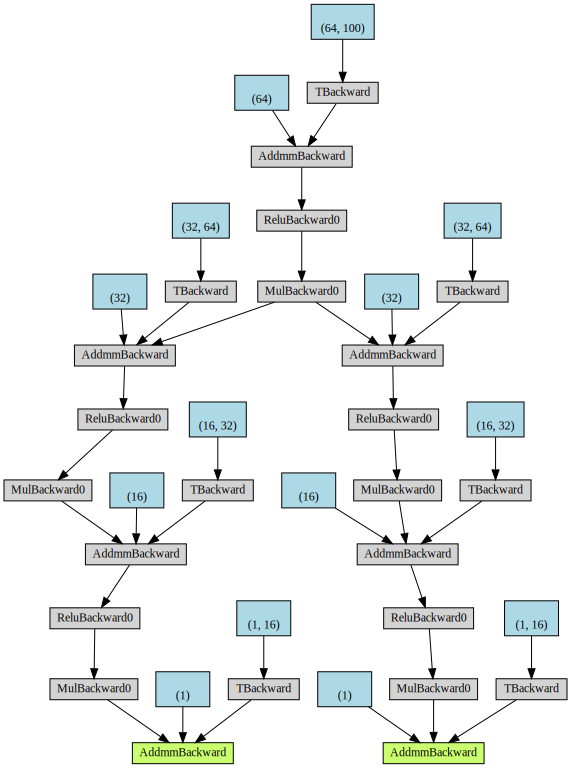

In [23]:
x = torch.randn(1,100)

#make_dot(MTL(x), params=dict(MTL.named_parameters()))
make_dot(MTL(x), params=None)

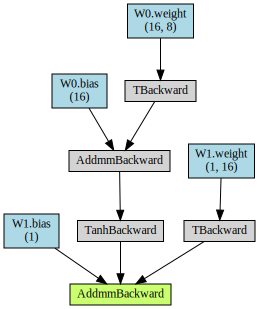

In [3]:
model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('W1', nn.Linear(16, 1))

x = torch.randn(1,8)

make_dot(model(x), params=dict(model.named_parameters()))

In [4]:
model = nn.Sequential()
model.add_module('W0', nn.Linear(8, 16))
model.add_module('tanh', nn.Tanh())
model.add_module('W1', nn.Linear(16, 1))

x = torch.randn(1,8)

with torch.onnx.set_training(model, False):
    trace, _ = torch.jit.get_trace_graph(model, args=(x,))
make_dot_from_trace(trace)

AttributeError: 'torch._C.Value' object has no attribute 'uniqueName'

In [4]:
parser = argparse.ArgumentParser(description = "Run CapsGNN.")

parser.add_argument("--train-graph-folder",
                    nargs = "?",
                    default = "../input/train/",
                help = "Training graphs folder.")

parser.add_argument("--test-graph-folder",
                    nargs = "?",
                    default = "../input/test/",
                help = "Testing graphs folder.")

parser.add_argument("--prediction-path",
                    nargs = "?",
                    default = "../output/watts_predictions.csv",
                help = "Path to store the predicted graph labels.")

parser.add_argument("--epochs",
                    type = int,
                    default = 1,
                help = "Number of training epochs. Default is 100.")

parser.add_argument("--batch-size",
                    type = int,
                    default = 32,
                help = "Number of graphs processed per batch. Default is 32.")

parser.add_argument("--gcn-filters",
                    type = int,
                    default = 20,
                help = "Number of Graph Convolutional filters. Default is 20.")

parser.add_argument("--gcn-layers",
                    type = int,
                    default = 2,
                help = "Number of Graph Convolutional Layers. Default is 2.")

parser.add_argument("--inner-attention-dimension",
                    type = int,
                    default = 20,
                help = "Number of Attention Neurons. Default is 20.")

parser.add_argument("--capsule-dimensions",
                    type = int,
                    default = 8,
                help = "Capsule dimensions. Default is 8.")

parser.add_argument("--number-of-capsules",
                    type = int,
                    default = 8,
                help = "Number of capsules per layer. Default is 8.")

parser.add_argument("--weight-decay",
                    type = float,
                    default = 10**-6,
                help = "Weight decay. Default is 10^-6.")

parser.add_argument("--learning-rate",
                    type = float,
                    default = 0.001,
                help = "Learning rate. Default is 0.01.")

parser.add_argument("--lambd",
                    type = float,
                    default = 0.5,
                help = "Loss combination weight. Default is 0.5.")

parser.add_argument("--theta",
                    type = float,
                    default = 0.1,
                help = "Reconstruction loss weight. Default is 0.1.")

_StoreAction(option_strings=['--theta'], dest='theta', nargs=None, const=None, default=0.1, type=<class 'float'>, choices=None, help='Reconstruction loss weight. Default is 0.1.', metavar=None)

In [5]:
args = parser.parse_known_args()[0]

usage: ipykernel_launcher.py [-h] [--train-graph-folder [TRAIN_GRAPH_FOLDER]]
                             [--test-graph-folder [TEST_GRAPH_FOLDER]]
                             [--prediction-path [PREDICTION_PATH]]
                             [--epochs EPOCHS] [--batch-size BATCH_SIZE]
                             [--gcn-filters GCN_FILTERS]
                             [--gcn-layers GCN_LAYERS]
                             [--inner-attention-dimension INNER_ATTENTION_DIMENSION]
                             [--capsule-dimensions CAPSULE_DIMENSIONS]
                             [--number-of-capsules NUMBER_OF_CAPSULES]
                             [--weight-decay WEIGHT_DECAY]
                             [--learning-rate LEARNING_RATE] [--lambd LAMBD]
                             [--theta THETA]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\khang\AppData\Roaming\jupyter\runtime\kernel-8a838da2-b558-4d39-b57b-094185af57a1.json


SystemExit: 2

D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3327: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
args = parser.parse_known_args()[0]
model = CapsGNNTrainer(args)
#model.fit()
#model.score()
#model.save_predictions()

 19%|██████████████▊                                                              | 829/4321 [00:00<00:00, 8230.08it/s]


Enumerating feature and target values.



100%|████████████████████████████████████████████████████████████████████████████| 4321/4321 [00:00<00:00, 8593.30it/s]


In [5]:
x = model.create_input_data('../input/test\graph_3025.json',4)

dot = make_dot(model.model(x), params=None)
dot.format = 'png'
dot.render('architecture_1')

'architecture_1.png'